In [13]:
#https://github.com/chengxi600/RLStuff/blob/master/Actor-Critic/Actor-Critic_TD_Lambda_Backward.ipynb

import math
import time
import random
from collections import deque
from collections import namedtuple
from dataclasses import dataclass

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  #activation function https://pytorch.org/docs/stable/nn.functional.html

from torch.distributions.categorical import Categorical

from torch.profiler import profile, record_function, ProfilerActivity

import gym
import rl_gym

import matplotlib.pyplot as plt

from tqdm import tqdm
import gc

In [14]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    


Using device: cpu


In [15]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 600

#early stopping
SOLVED_SCORE = 0

#device to run model on 
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"

#Lambda constant for actor
ACTOR_LAMBDA = 0.5

#lambda constant for critic
CRITIC_LAMBDA = 0.5

#actor learning rate
ACTOR_LR = 0.0001

#critic learning rate
CRITIC_LR = 0.0001

In [16]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.hidden_layer = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    #forward pass, return action probabilities
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        return F.softmax(self.output_layer(x), dim=1)

In [17]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.hidden_layer = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, 1)
    
    #forward pass, return state value function
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer(x))
        return self.output_layer(x)    

In [18]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    state.requires_grad = True
    
    #use network to predict action probabilities
    action_probs = network(state)
    state = state.detach()
    
    #sample an action using the probability distribution
    m = Categorical(probs=action_probs)
    action = m.sample()
    
    #return action
    return action.item(), m.log_prob(action)

In [19]:
#Make environment
#env = gym.make('CartPole-v1')
env = gym.make("rl_gym/PuckWorld-v0", fps=60)

#Init network
policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n).to(DEVICE)
stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)

#Note that we aren't initializing optimizers because we will be manually doing the update instead so we can use trace

pygame 2.1.0 (SDL 2.0.16, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [20]:
#track scores
scores = []

#track recent scores
recent_scores = deque(maxlen = 10)

#run episodes
pbar = tqdm(range(NUM_EPISODES))

for episode in pbar:
    
    #init variables
    state = env.reset()
    done = False
    score = 0
    I = 1
    actor_trace = []
    critic_trace = []
    
    #run episode, update online
    for step in range(MAX_STEPS):
        
        #get action and log probability
        action, lp = select_action(policy_network, state)
        
        #step with action
        new_state, reward, done, _ = env.step(action)
        
        #update episode score
        score += reward

        #update actor trace
        policy_network.zero_grad()
        lp.backward(retain_graph=True)

        if not actor_trace: 
            with torch.no_grad():
                for p in policy_network.parameters():
                    #initialize trace 
                    trace = I * p.grad
                    actor_trace.append(trace)
        else:
            with torch.no_grad():
                for i, p in enumerate(policy_network.parameters()):
                    #decay trace and shift trace in direction of most recent gradient
                    actor_trace[i] = actor_trace[i] * ACTOR_LAMBDA * DISCOUNT_FACTOR + I * p.grad
        
        #get state value of current state
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_tensor.requires_grad = True
        state_val = stateval_network(state_tensor)

        #update critic trace
        stateval_network.zero_grad()
        state_val.backward()

        if not critic_trace:
            with torch.no_grad():
                for p in stateval_network.parameters():
                    #initialize trace
                    trace = p.grad
                    critic_trace.append(trace)
        else:
            with torch.no_grad():
                for i, p in enumerate(stateval_network.parameters()):
                    #decay trace and shift trace in direction of most recent gradient
                    critic_trace[i] = critic_trace[i] * CRITIC_LAMBDA * DISCOUNT_FACTOR + p.grad


        
        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
        new_state_val = stateval_network(new_state_tensor)
        
        #if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)
        
        #calculate advantage
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        
        #Backpropagate policy
        policy_network.zero_grad()
        #update parameters with trace
        with torch.no_grad():
            for i, p in enumerate(policy_network.parameters()):
                new_val = p + ACTOR_LR * advantage * actor_trace[i]
                p.copy_(new_val)
        
        #Backpropagate value
        stateval_network.zero_grad()
        #update parameters with trace
        with torch.no_grad():
            for i, p in enumerate(stateval_network.parameters()):
                new_val = p + CRITIC_LR * advantage * critic_trace[i]
                p.copy_(new_val)
        
        if done:
            break
            
        #move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR
    
    #append episode score 
    scores.append(score)
    recent_scores.append(score)
    pbar.set_description(f'score:{np.mean(recent_scores):.0f}')
    pbar.refresh()
    
    
    #early stopping if we meet solved score goal
    #if np.array(recent_scores).mean() >= SOLVED_SCORE:
    #    break
        

score:-437: 100%|██████████████████████████████████████████████████████████████████| 1000/1000 [25:27<00:00,  1.53s/it]


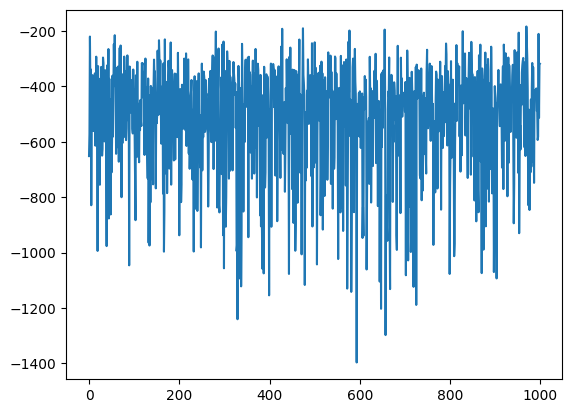

In [21]:
plt.plot(scores)